In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import librosa
import librosa.display

2024-01-15 10:23:01.260668: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load data and metadata

In [3]:
data = pickle.load(open(f"/datasets/nicolas_facchinetti/adv/jsma.p", "rb"))
data

{'emodb': {-1: array([[[[ 2.5515871e+00],
           [ 2.5004048e+00],
           [ 2.9713099e+00],
           ...,
           [ 1.6413774e-02],
           [ 2.0089759e-02],
           [ 2.1665324e-02]],
  
          [[ 1.0150692e+00],
           [ 1.0845283e+00],
           [ 1.3613745e+00],
           ...,
           [ 9.0140235e-03],
           [ 1.6475219e-02],
           [ 1.8647948e-02]],
  
          [[ 2.0068274e+00],
           [ 1.8613292e+00],
           [-5.3981412e-02],
           ...,
           [ 4.7419579e-03],
           [ 1.4878303e-02],
           [ 1.9983673e-02]],
  
          ...,
  
          [[ 2.1270056e+00],
           [ 2.0346293e+00],
           [-8.2880956e-01],
           ...,
           [ 3.6282430e-03],
           [ 1.4886921e-02],
           [ 1.9904863e-02]],
  
          [[ 1.9533772e+00],
           [ 1.9076465e+00],
           [ 1.4032218e+00],
           ...,
           [ 5.7982551e-03],
           [ 1.6895652e-02],
           [ 2.0862831e-02]],
  

In [4]:
attackEmodb = data['emodb'][1]
attackEmovo = data['emovo'][1]
attackRavdess = data['ravdess'][1]

In [5]:
attackEmodb.shape

(837, 261, 128, 1)

In [6]:
attackEmovo.shape

(987, 261, 128, 1)

In [7]:

attackRavdess.shape

(1791, 261, 128, 1)

In [8]:
def load_dataset(dsname):
    metadata = pd.read_csv(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/metadata_final.csv")
    x = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data0.p", "rb" ))
    return metadata, x

In [9]:
from sklearn.preprocessing import StandardScaler

datasets = ["emodb", "emovo", "ravdess"]
scalers = {d: StandardScaler() for d in datasets}

data = {}
for d in datasets:
    md, x = load_dataset(d)
    data[d] = {}
    # standardize data
    n = x.shape
    scalers[d].fit_transform(x.reshape(n[0],-1))
    data[d]["x"] = x
    data[d]["metadata"] = md

In [10]:
x[0].shape

(261, 128, 1)

In [11]:
data['emodb']['metadata'].head()

,path,filename,chunk,label,actor,gender,mod
0,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,0
1,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,0
2,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1
3,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,1
4,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1


In [12]:
data['emodb'].keys()

dict_keys(['x', 'metadata'])

Get train/test data

In [13]:
from sklearn.model_selection import train_test_split

test = {}
test_md = {}
for d in datasets:
    test[d] = {}
    train_df, test_df = train_test_split(data[d]['metadata'], 
                                       test_size = 0.2, 
                                       random_state = 1938,
                                       stratify = data[d]['metadata']['label'])
    test_md[d] = test_df.reset_index()
    test_index = test_df.index
    print(f'For {d}:\ttest size {len(test_index)}')
    test[d]['x']= data[d]['x'][test_index]
    

For emodb:	test size 837
For emovo:	test size 987
For ravdess:	test size 1791


In [14]:
for f in data:
    del data[f]['metadata']
    del data[f]['x']
del data

import gc
gc.collect()

517

# Image generation test

In [15]:
def standardize(sample, dataset_name):
    return scalers[dataset_name].transform(sample.reshape((1, -1))).reshape(sample.shape)

def destandardize(sample, dataset_name):
    return scalers[dataset_name].inverse_transform(sample.reshape((1, -1))).reshape(sample.shape)


def generate_spectrogram(samples):
    librosa.display.specshow(samples, sr=16000, n_fft=368, hop_length=184, x_axis='time', y_axis='mel')

In [16]:
 np.squeeze(test['emodb']['x'][0], axis=2).transpose().shape

(128, 261)

In [17]:
def modShape(data):
    return np.squeeze(data, axis=2).transpose()

def demodShape(data):
    return data.T[..., None]

(Mean, std) of the below spectrogram: (-0.118, 0.612)


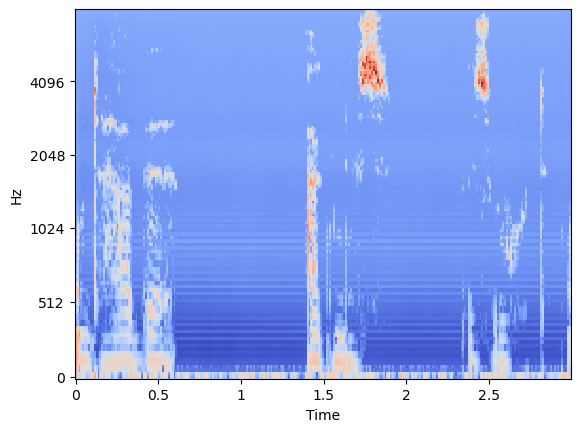

In [18]:
immTest = standardize(test['emodb']['x'][0], 'emodb')
generate_spectrogram(modShape(immTest))
print(f"(Mean, std) of the below spectrogram: ({immTest.mean():.3f}, {immTest.std():.3f})")

In [19]:
immTest= attackEmodb[0]
myShape = immTest.shape
myShape

(261, 128, 1)

In [20]:
# myShape = attackEmodb.shape
# print(myShape)
# immTestMod = scalers["emodb"].inverse_transform(attackEmodb.reshape(myShape[0],-1)).reshape(myShape)[0]
# immTestMod.shape

(Mean, std) of the below spectrogram: (-0.113, 0.637)


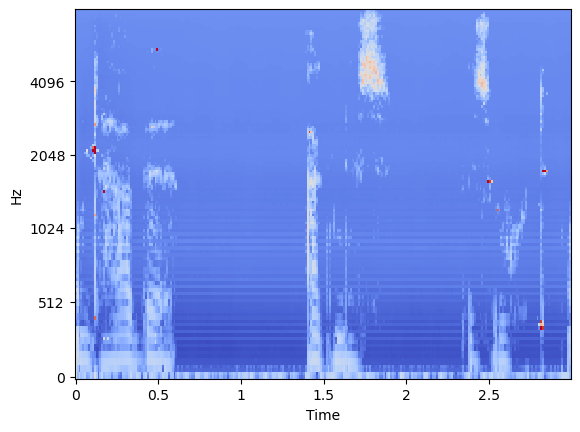

In [21]:
# generate_spectrogram(modShape(immTestMod))
generate_spectrogram(modShape(immTest))
print(f"(Mean, std) of the below spectrogram: ({immTest.mean():.3f}, {immTest.std():.3f})")

# Image generation Male/Female for the three datasets

Rimetto i dati generati sulla loro scala originale

In [22]:
# shapeEmodb=  attackEmodb.shape
# shapeEmovo =  attackEmovo.shape
# shapeRavdess =  attackRavdess.shape

# attackEmodbRS = scalers["emodb"].inverse_transform(attackEmodb.reshape(shapeEmodb[0],-1)).reshape(shapeEmodb)
# attackEmovoRS = scalers["emovo"].inverse_transform(attackEmovo.reshape(shapeEmovo[0],-1)).reshape(shapeEmovo)
# attackRavdessRS = scalers["ravdess"].inverse_transform(attackRavdess.reshape(shapeRavdess[0],-1)).reshape(shapeRavdess)

In [23]:
test_md["emodb"][(test_md["emodb"]['mod'] == 0) & (test_md["emodb"]['label'] == 'happy')].head(10)

,index,path,filename,chunk,label,actor,gender,mod
9,2647,/datasets/nicolas_facchinetti/emodb/data/11a05...,11a05Fc.wav,1,happy,11,m,0
53,1907,/datasets/nicolas_facchinetti/emodb/data/13a07...,13a07Fd.wav,0,happy,13,f,0
59,2308,/datasets/nicolas_facchinetti/emodb/data/16b03...,16b03Fa.wav,0,happy,16,f,0
67,3318,/datasets/nicolas_facchinetti/emodb/data/16a07...,16a07Fb.wav,0,happy,16,f,0
87,683,/datasets/nicolas_facchinetti/emodb/data/03a04...,03a04Fd.wav,0,happy,3,m,0
88,215,/datasets/nicolas_facchinetti/emodb/data/08b03...,08b03Fe.wav,1,happy,8,f,0
96,3728,/datasets/nicolas_facchinetti/emodb/data/15a05...,15a05Fb.wav,0,happy,15,m,0
133,3363,/datasets/nicolas_facchinetti/emodb/data/10a02...,10a02Fa.wav,0,happy,10,m,0
176,2738,/datasets/nicolas_facchinetti/emodb/data/11a04...,11a04Fd.wav,0,happy,11,m,0
243,2475,/datasets/nicolas_facchinetti/emodb/data/13b02...,13b02Fb.wav,0,happy,13,f,0


In [24]:
test_md["emovo"][(test_md["emovo"]['mod'] == 0)  & (test_md["emovo"]['label'] == 'happy')].head(10)

,index,path,filename,chunk,label,actor,gender,mod
17,3927,/datasets/nicolas_facchinetti/emovo/data/m1/gi...,gio-m1-l2.wav,1,happy,m1,m,0
66,3041,/datasets/nicolas_facchinetti/emovo/data/f3/gi...,gio-f3-n2.wav,0,happy,f3,f,0
107,4218,/datasets/nicolas_facchinetti/emovo/data/m2/gi...,gio-m2-n2.wav,0,happy,m2,m,0
188,2856,/datasets/nicolas_facchinetti/emovo/data/f3/gi...,gio-f3-n3.wav,0,happy,f3,f,0
277,1665,/datasets/nicolas_facchinetti/emovo/data/f2/gi...,gio-f2-n3.wav,0,happy,f2,f,0
354,4369,/datasets/nicolas_facchinetti/emovo/data/m2/gi...,gio-m2-l3.wav,0,happy,m2,m,0
616,4145,/datasets/nicolas_facchinetti/emovo/data/m2/gi...,gio-m2-b3.wav,0,happy,m2,m,0
665,2599,/datasets/nicolas_facchinetti/emovo/data/f3/gi...,gio-f3-l3.wav,1,happy,f3,f,0
693,115,/datasets/nicolas_facchinetti/emovo/data/m3/gi...,gio-m3-b2.wav,0,happy,m3,m,0
697,3334,/datasets/nicolas_facchinetti/emovo/data/m1/gi...,gio-m1-l3.wav,0,happy,m1,m,0


In [25]:
test_md["ravdess"][(test_md["ravdess"]['mod'] == 0)  & (test_md["ravdess"]['label'] == 'happy')].head(10)

,index,path,filename,chunk,label,actor,gender,mod
0,6357,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-01-01-02-24.wav,0,happy,Actor_24,f,0
60,8068,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-01-02-01-06.wav,0,happy,Actor_06,f,0
70,1995,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-01-01-01-18.wav,0,happy,Actor_18,f,0
102,5175,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-01-01-01-07.wav,0,happy,Actor_07,m,0
177,5094,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-02-01-01-07.wav,0,happy,Actor_07,m,0
267,3502,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-02-02-02-05.wav,0,happy,Actor_05,m,0
270,3474,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-02-01-01-05.wav,0,happy,Actor_05,m,0
303,7502,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-01-02-01-09.wav,0,happy,Actor_09,m,0
337,7594,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-01-01-02-09.wav,0,happy,Actor_09,m,0
338,8853,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-03-02-01-01-13.wav,0,happy,Actor_13,m,0


Scegliamo un Maschio e Femmina per ogni sample e stampiamo a video i dati

In [26]:
emodbM = 87
emodbF = 53
d1OM = modShape(standardize(test['emodb']['x'][emodbM], 'emodb'))
d1AM = modShape(attackEmodb[emodbM])
d1OF = modShape(standardize(test['emodb']['x'][emodbF], 'emodb'))
d1AF = modShape(attackEmodb[emodbF])

emovoM = 107
emovoF = 66
d2OM = modShape(standardize(test['emovo']['x'][emovoM], 'emovo'))
d2AM = modShape(attackEmovo[emovoM])
d2OF = modShape(standardize(test['emovo']['x'][emovoF], 'emovo'))
d2AF = modShape(attackEmovo[emovoF])

ravdessM = 177
ravdessF = 60
d3OM = modShape(standardize(test['ravdess']['x'][ravdessM], 'ravdess'))
d3AM = modShape(attackRavdess[ravdessM])
d3OF = modShape(standardize(test['ravdess']['x'][ravdessF], 'ravdess'))
d3AF = modShape(attackRavdess[ravdessF])

## EMODB

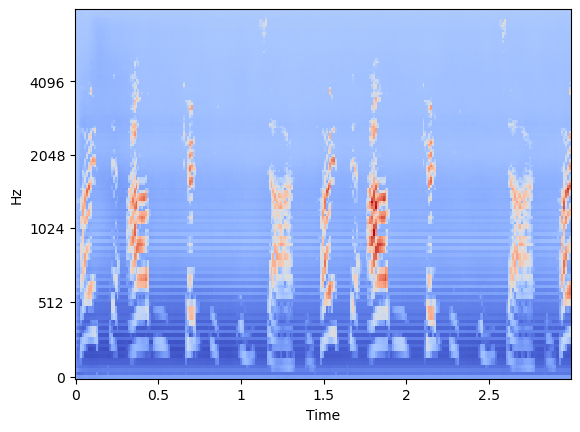

In [27]:
generate_spectrogram(d1OM)

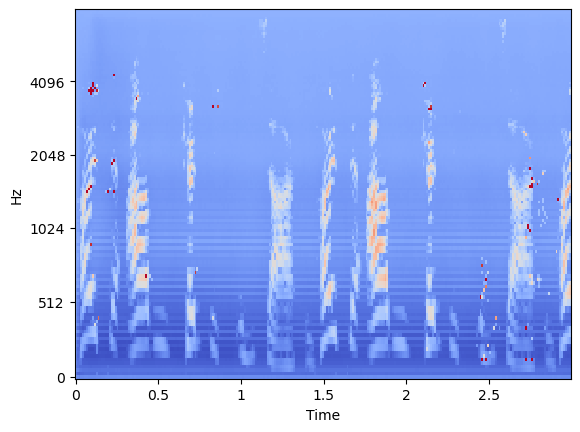

In [28]:
generate_spectrogram(d1AM)

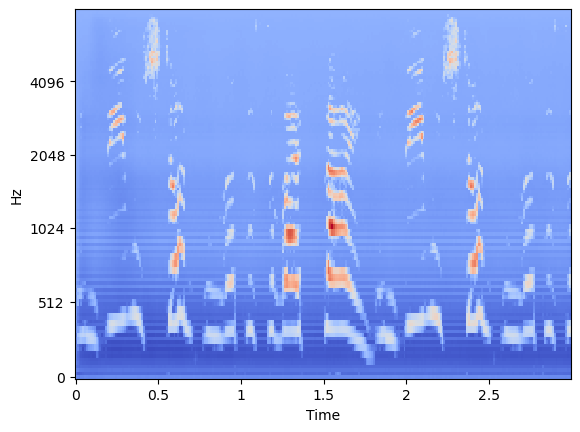

In [29]:
generate_spectrogram(d1OF)

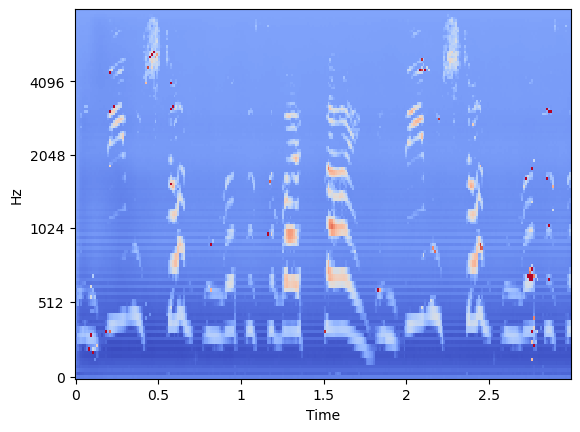

In [30]:
generate_spectrogram(d1AF)

## EMOVO

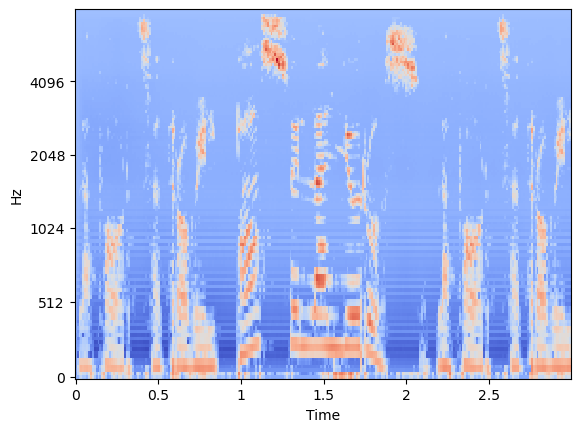

In [31]:
generate_spectrogram(d2OM)

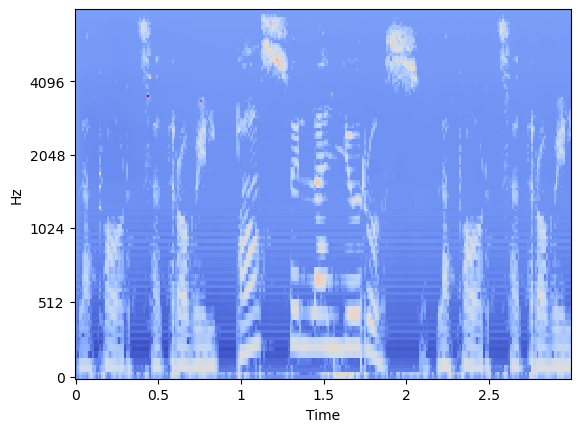

In [32]:
generate_spectrogram(d2AM)

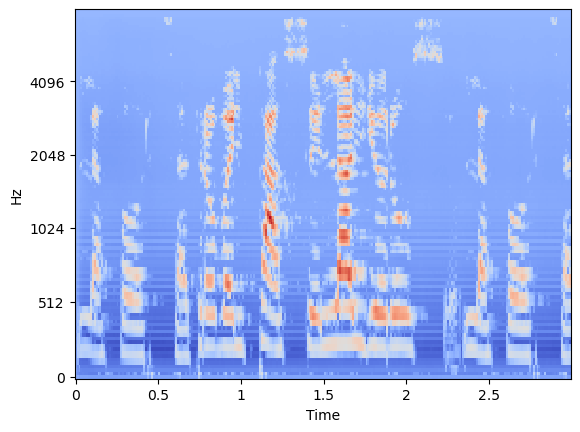

In [33]:
generate_spectrogram(d2OF)

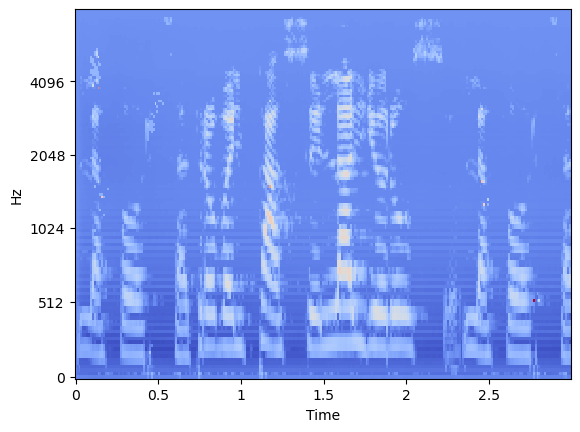

In [34]:
generate_spectrogram(d2AF)

## Ravdess

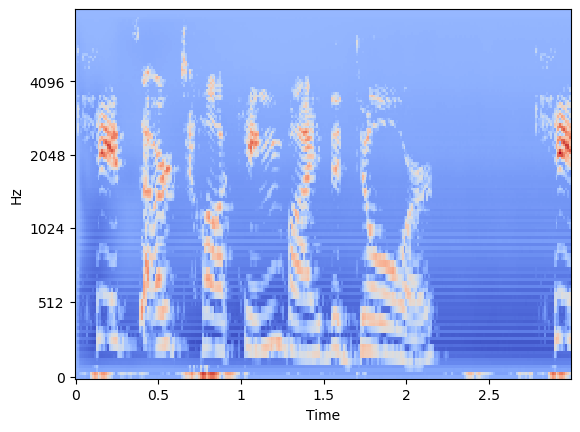

In [35]:
generate_spectrogram(d3OM)

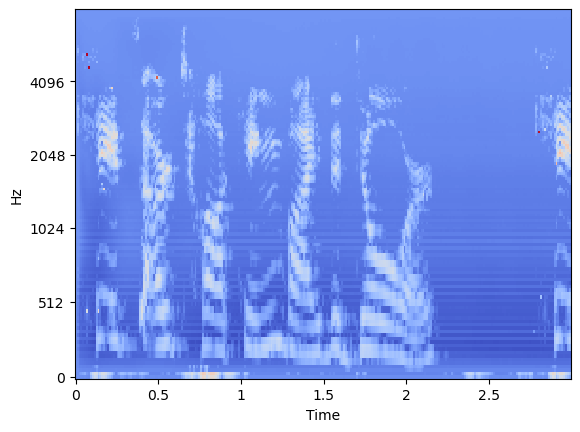

In [36]:
generate_spectrogram(d3AM)

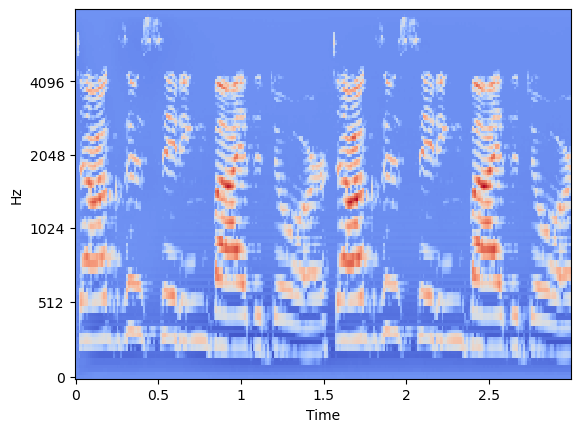

In [37]:
generate_spectrogram(d3OF)

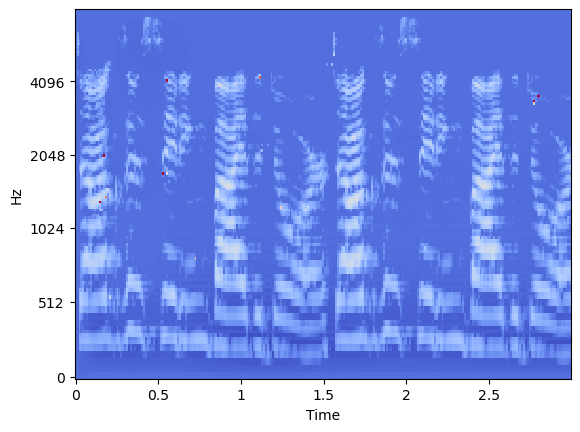

In [38]:
generate_spectrogram(d3AF)

# Audio generation

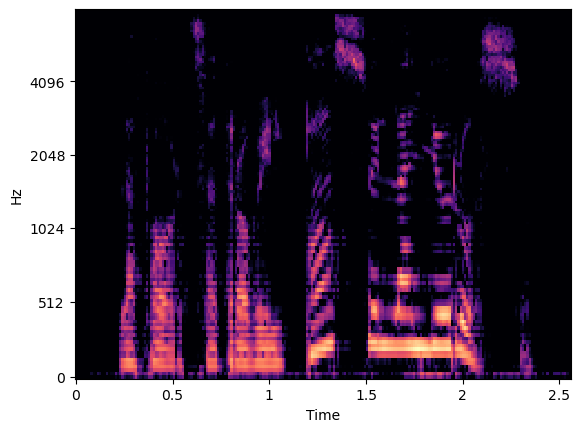

In [39]:
import IPython
import librosa

path = test_md['emovo'].loc[emovoM, 'path']
audio = librosa.load(path, sr=16000)[0]
mel = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=368, hop_length=184, n_mels=128)
mel = librosa.amplitude_to_db(mel, ref=np.min)
generate_spectrogram(mel)

In [40]:
IPython.display.Audio(audio, rate=16000)

(261, 128, 1)
(128, 261)


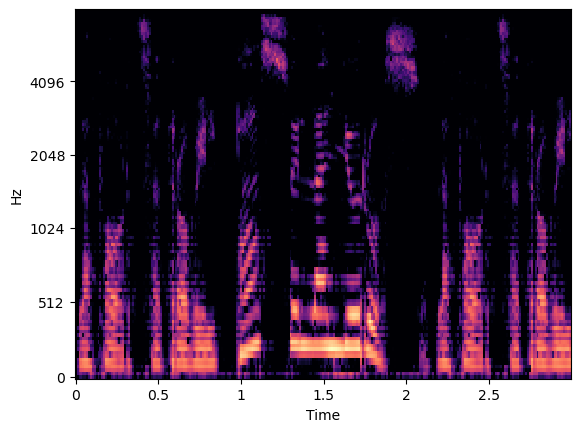

In [41]:
d2OM_test = test['emovo']['x'][emovoM]
d2OM_destd = modShape(destandardize(demodShape(d2OM), 'emovo'))
print(d2OM_test.shape)
print(d2OM_destd.shape)

d2OM_test = modShape(d2OM_test)
generate_spectrogram(d2OM_test)

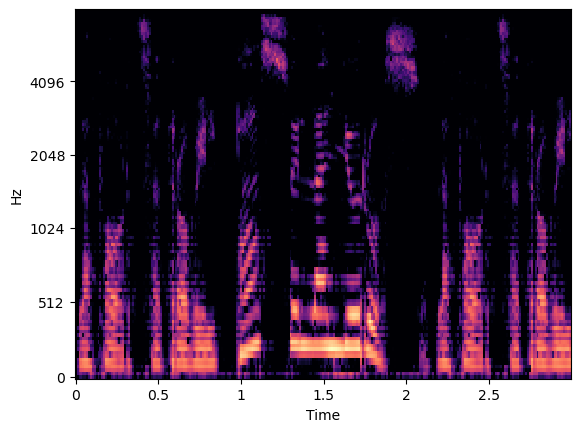

In [42]:
generate_spectrogram(d2OM_destd)

In [43]:
d2OM_amplitude = librosa.db_to_amplitude(d2OM_test)

In [44]:
# s = librosa.istft(stft_from_mel, hop_length=184, n_fft=368 )
# s.shape
s = librosa.feature.inverse.mel_to_audio(d2OM_amplitude, sr=16000, n_fft=368, hop_length=184, power=1)
s.shape

(47840,)

In [45]:
import IPython
IPython.display.Audio(s, rate=16000)

0.00067691365 6130.625 141.28506
Found 23.38% outliers


array([   1.9812492,    1.182252 ,    0.6524885, ...,  -50.099056 ,
       -100.61342  ,  -52.90031  ], dtype=float32)

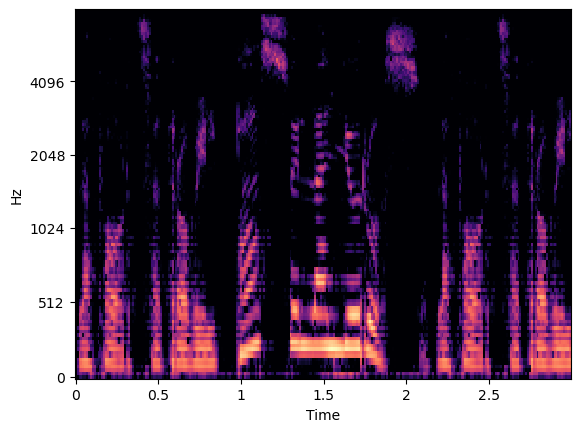

In [85]:
def backToAudioPlay(spectro, dataset_name):
    spectro = demodShape(spectro)
    spectro = destandardize(spectro, dataset_name)
    spectro = modShape(spectro)
    generate_spectrogram(spectro)
    mel_spectrogram = librosa.db_to_power(spectro)
    audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=16000, n_fft=368, hop_length=184, power=2)
    return audio

import soundfile as sf
from pathlib import Path
out_path = 'audio_examples'
Path(out_path).mkdir(exist_ok=True)
from sklearn.ensemble import IsolationForest 
def outlier_removal(audio):
    audio_ = np.abs(audio[:, None])
    print(np.min(audio_), np.max(audio_), np.median(audio_))
    audio_no_zero = np.argwhere(audio_ > np.median(audio_) / 1000)[:, 0]
    outliers = IsolationForest().fit_predict(audio_[audio_no_zero]) == -1
    print(f"Found {outliers.sum() / audio.shape[0] * 100:.2f}% outliers")
    outliers = audio_no_zero[outliers]
    audio[outliers] = 0
    return audio
s = backToAudioPlay(d2OM, 'emovo')
IPython.display.Audio(s, rate=16000, normalize=True)
outlier_removal(s)

## EmoDB

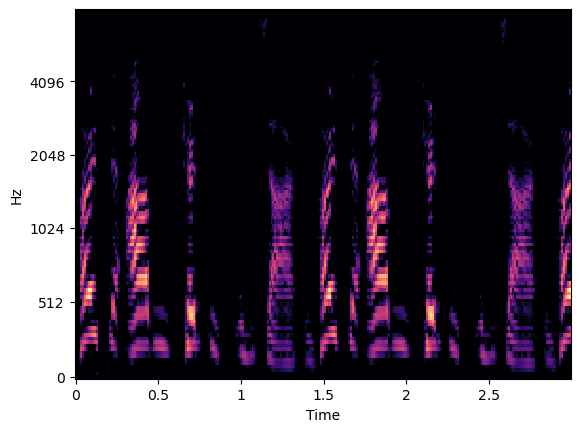

In [55]:
s = backToAudioPlay(d1OM, 'emodb')
sf.write(out_path + '/d1OM.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

0.010114874 37401133000.0 1726.9878
Found 7.10% outliers


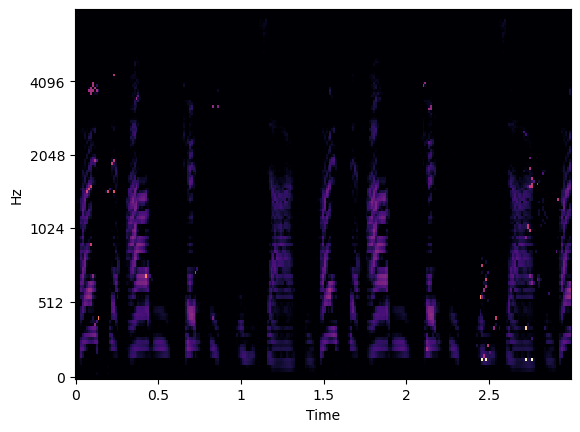

In [86]:
s = backToAudioPlay(d1AM, 'emodb')
sf.write(out_path + '/d1AM.wav', s / np.abs(s).max(), 16000)
s = outlier_removal(s)
sf.write(out_path + '/d1AM_no_outlier.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

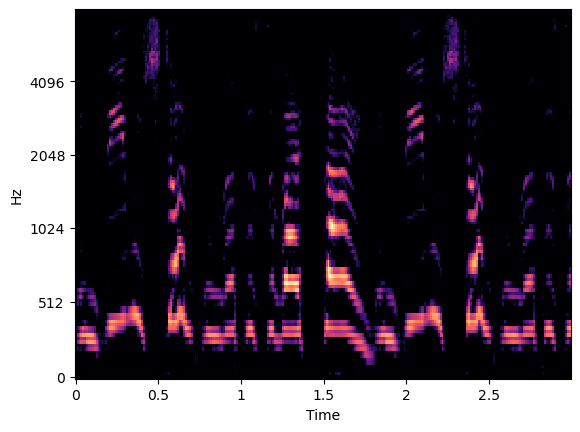

In [48]:
s = backToAudioPlay(d1OF, 'emodb')
sf.write(out_path + '/d1OF.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

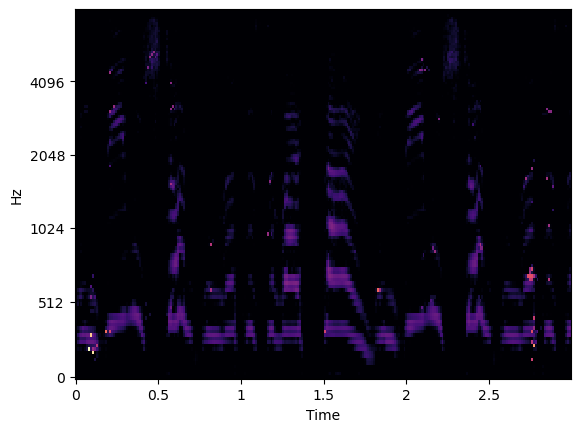

In [49]:
s = backToAudioPlay(d1AF, 'emodb')
sf.write(out_path + '/d1AF.wav', s / np.abs(s).max(), 16000)
s = outlier_removal(s)
sf.write(out_path + '/d1AF_no_outlier.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

## EMOVO

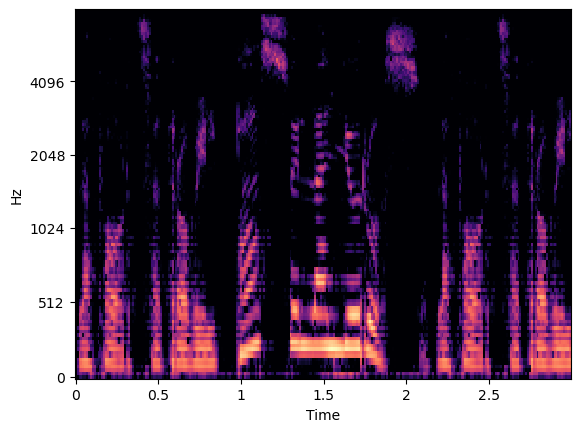

In [50]:
s = backToAudioPlay(d2OM, 'emovo')
sf.write(out_path + '/d2OM.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

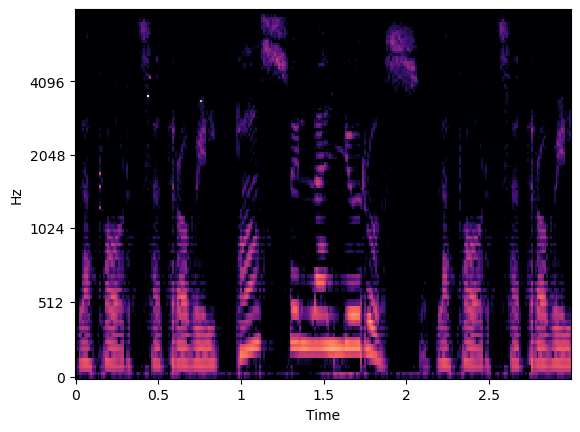

In [51]:
s = backToAudioPlay(d2AM, 'emovo')
sf.write(out_path + '/d2AM.wav', s / np.abs(s).max(), 16000)
s = outlier_removal(s)
sf.write(out_path + '/d2AM_no_outlier.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

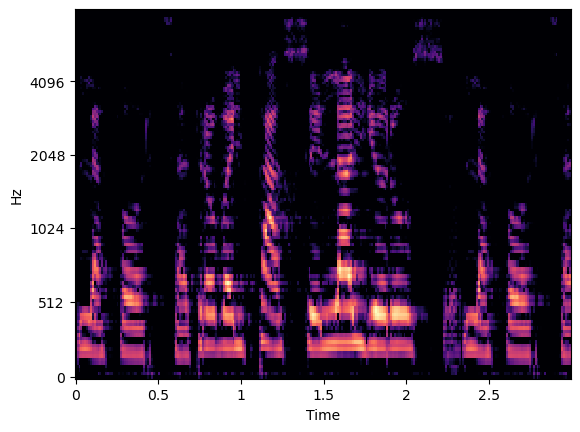

In [52]:
s = backToAudioPlay(d2OF, 'emovo')
sf.write(out_path + '/d2OF.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

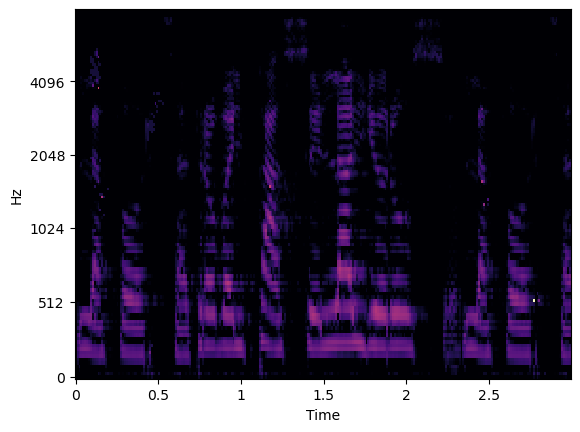

In [53]:
s = backToAudioPlay(d2AF, 'emovo')
sf.write(out_path + '/d2AF.wav', s / np.abs(s).max(), 16000)
s = outlier_removal(s)
sf.write(out_path + '/d2AF_no_outlier.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

## Ravdess

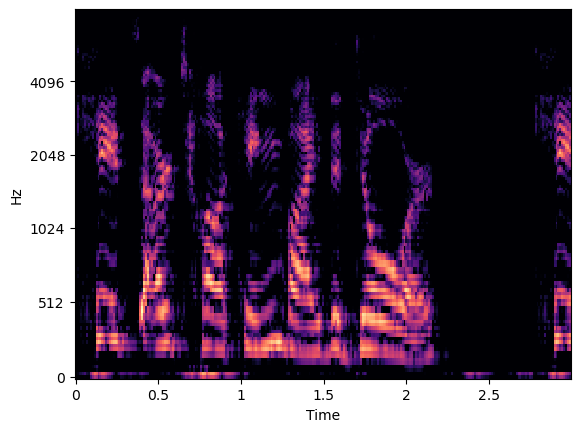

In [54]:
s = backToAudioPlay(d3OM, 'ravdess')
IPython.display.Audio(s, rate=16000)
sf.write(out_path + '/d3OM.wav', s / np.abs(s).max(), 16000)

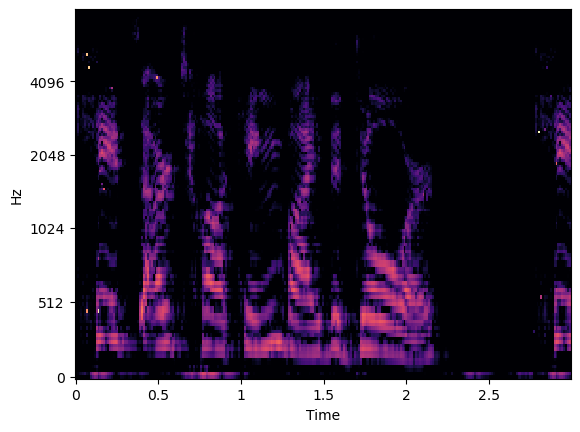

In [55]:
s = backToAudioPlay(d3AM, 'ravdess')
sf.write(out_path + '/d3AM.wav', s / np.abs(s).max(), 16000)
s = outlier_removal(s)
sf.write(out_path + '/d3AM_no_outlier.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)

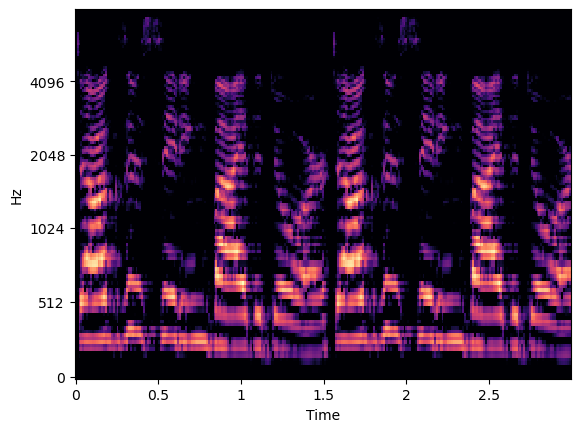

In [56]:
s = backToAudioPlay(d3OF, 'ravdess')
sf.write(out_path + '/d3OF.wav', s / np.abs(s).max(), 16000)

IPython.display.Audio(s, rate=16000)

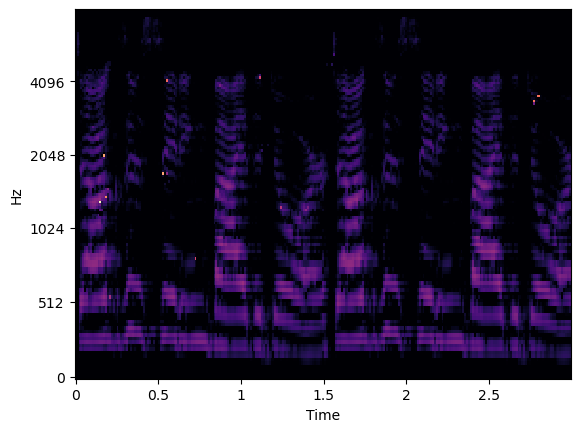

In [57]:
s = backToAudioPlay(d3AF, 'ravdess')
sf.write(out_path + '/d3AF.wav', s / np.abs(s).max(), 16000)
s = outlier_removal(s)
sf.write(out_path + '/d3AF_no_outlier.wav', s / np.abs(s).max(), 16000)
IPython.display.Audio(s, rate=16000)